# Data

In [1]:
import pandas as pd
import numpy as np
from SupportFunctions import preprocess_impute_spaceship_titanic

In [2]:
test_raw = pd.read_csv("./spaceship-titanic/test.csv")

In [3]:
def bin_feature(df, feat_name, bins):
    """
    Put feature in bins and drop old column.
    
    Returns dataframe with new feature.
    """
    
    new_df = df.copy()
    
    # Transform to int64 column with NaNs for string 'Missing'
    new_df[feat_name] = new_df[feat_name].map(lambda x: np.NaN if x=="Missing" else x).astype('Int64', errors='ignore') # Missing is Nan again
    
    # Cut in bins
    new_df[feat_name] = pd.cut(new_df[feat_name], bins=bins, include_lowest=True)
    
    return new_df

In [4]:
# Bin features is dict
from sklearn.preprocessing import LabelEncoder

def read_preprocess_titanic(cat_features,
                            drop_features,
                            bin_features,
                            one_hot=True,
                            label_encode=False,
                            drop_first_label=False,
                            log_transform_exp=False,
                            proba_imp=True,
                            expense_strat="group_median",
                            age_strat="group_mean",
                            drop_outliers=False):

    train_raw = pd.read_csv("./spaceship-titanic/train.csv")
    test_raw = pd.read_csv(("./spaceship-titanic/test.csv"))


    # Preprocess train 
    train = preprocess_impute_spaceship_titanic(train_raw, 
                                                log_transform_exp=log_transform_exp, 
                                                proba_imp=proba_imp, 
                                                expense_strat=expense_strat, 
                                                age_strat=age_strat,
                                                drop_outliers=drop_outliers)

    # Preprocess test in same way
    test = preprocess_impute_spaceship_titanic(test_raw, 
                                               log_transform_exp=log_transform_exp, 
                                               proba_imp=proba_imp, 
                                               expense_strat=expense_strat, 
                                               age_strat=age_strat,
                                               drop_outliers=drop_outliers)
    
    # Bin features
    for name, feat_bins in bin_features.items():
        train = bin_feature(train, name, bins=feat_bins)
        test = bin_feature(test, name, bins=feat_bins)
        
        # Add feature to categorical features
        cat_features.append(name)
        
    
    # Convert to dummies 
    if one_hot:
        train = pd.concat([train, pd.get_dummies(train[cat_features], drop_first=drop_first_label)], axis=1)
        train = train.drop(cat_features, axis=1)
        
        test = pd.concat([test, pd.get_dummies(test[cat_features], drop_first=drop_first_label)], axis=1)
        test = test.drop(cat_features, axis=1)
    
    # Encode as labels
    elif label_encode:
        for feat in cat_features:
            LE = LabelEncoder().fit(train[feat])
            train[feat] = LE.transform(train[feat])
            test[feat] = LE.transform(test[feat])
    
    else:
        pass
            
    # Drop features
    train = train.drop(drop_features, axis=1)

    # Same for test
    test = test.drop(drop_features, axis=1)


    y = train.Transported.copy()
    X = train.drop("Transported", axis=1).copy()
    
    return X, test, y

In [5]:
#Categorical features we want to include in the models
cat_features = ['HomePlanet', 'Destination', 'Deck', 'Side']
bool_features = ['CryoSleep', 'VIP', 'NoExpenses', 'Alone']
drop_features = ['PassengerId', 'Name', 'GroupID', 'CabinNum']
num_features = ['Age', 'TotalExp', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupPos']

# DecTree

In [406]:
X, test, y = read_preprocess_titanic(cat_features=['HomePlanet', 'Destination', 'Deck', 'Side'],
                                     drop_features=['PassengerId', 'Name'],
                                     bin_features={'CabinNum':(0, 473, 947, 1420, 1895)},
                                     one_hot=True)


In [174]:
from sklearn.feature_selection import RFECV

base = RandomForestClassifier(n_estimators=800, max_depth=8)
selector = RFECV(base, cv=5, n_jobs=-1)
#np.mean(cross_val_score(RandomForestClassifier(), X, y, cv=10))

In [175]:
selector.fit(X,y)

RFECV(cv=5, estimator=RandomForestClassifier(max_depth=8, n_estimators=800),
      n_jobs=-1)

In [177]:
selector.feature_names_in_[selector.support_]

array(['CryoSleep', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'TotalExp', 'GroupID', 'GroupSize', 'NoExpenses',
       'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'Deck_E', 'Deck_F', 'Deck_G', 'Side_S'], dtype=object)

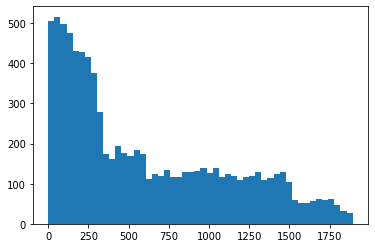

In [19]:
import matplotlib.pyplot as plt

plt.hist(X[X.CabinNum!="Missing"].CabinNum.astype(int), bins=50)
plt.show()

(array([4541., 1725., 1531.,  797.]),
 array([   0. ,  473.5,  947. , 1420.5, 1894. ]),
 <BarContainer object of 4 artists>)

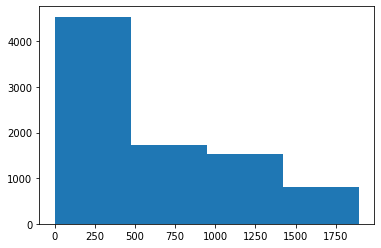

In [23]:
# Do it in 4
plt.hist(X[X.CabinNum!="Missing"].CabinNum.astype(int), bins=4)

In [110]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   HomePlanet    8693 non-null   category
 1   CryoSleep     8693 non-null   bool    
 2   Destination   8693 non-null   category
 3   Age           8693 non-null   int64   
 4   VIP           8693 non-null   bool    
 5   RoomService   8693 non-null   float64 
 6   FoodCourt     8693 non-null   float64 
 7   ShoppingMall  8693 non-null   float64 
 8   Spa           8693 non-null   float64 
 9   VRDeck        8693 non-null   float64 
 10  TotalExp      8693 non-null   float64 
 11  GroupPos      8693 non-null   int64   
 12  GroupSize     8693 non-null   int64   
 13  Deck          8693 non-null   category
 14  CabinNum      8594 non-null   category
 15  Side          8693 non-null   category
 16  NoExpenses    8693 non-null   bool    
 17  Alone         8693 non-null   bool    
dtypes: bool(

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier


param_grid = {'max_features': [None, 'sqrt', 'log2'],
              'max_depth' : [5, 6, 7, 8, 9, 10, 11, 12],
              'criterion' :['gini', 'entropy'],
              'min_samples_split': [2, 4, 10, 15, 20, 25, 30, 35, 50], 
              'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 10, 50]
             }

decTree = DecisionTreeClassifier(random_state=123)
grid_search_DT = GridSearchCV(estimator=decTree, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search_DT.fit(X, y)

Fitting 5 folds for each of 4320 candidates, totalling 21600 fits


KeyboardInterrupt: 

In [214]:
param_grid = {'max_features': [None],
              'max_depth' : [5, 6, 7, 8, 9, 10, 11, 12],
              'criterion' :['gini', 'entropy'],
              'min_samples_split': [2, 4, 10], 
              'min_samples_leaf': [5, 6, 7, 8, 10]
             }

decTree = DecisionTreeClassifier(random_state=123)
grid_search_DT = GridSearchCV(estimator=decTree, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search_DT.fit(X, y)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7, 8, 9, 10, 11, 12],
                         'max_features': [None],
                         'min_samples_leaf': [5, 6, 7, 8, 10],
                         'min_samples_split': [2, 4, 10]},
             verbose=1)

In [59]:
grid_search_DT.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 8,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 123,
 'splitter': 'best'}

In [60]:
grid_search_DT.best_score_

0.7882218065089058

In [61]:
decTreePred = grid_search_DT.best_estimator_.predict(test)

decTreeSub = test_raw[["PassengerId"]].copy()
decTreeSub["Transported"] = decTreePred

decTreeSub.to_csv("./spaceship-titanic/DecTree.csv", index=False)

# RF

In [279]:
X, test, y = read_preprocess_titanic(cat_features=['HomePlanet', 'Destination', 'Deck', 'Side'],
                                     drop_features=['PassengerId', 'Name', 'GroupPos', 'CabinNum', 'GroupID'],
                                     bin_features={},
                                     one_hot=True)

# from feat imp, but got worse
X = X.drop(['VIP', 'Alone', 'Deck_T', 'Side_Missing'], axis=1)
test = test.drop(['VIP', 'Alone', 'Deck_T', 'Side_Missing'], axis=1)

In [ ]:
# Cabin num bin_features={'CabinNum':(0, 473, 947, 1420, 1895)

#'criterion' :['gini', 'entropy'],
#    'min_samples_split': [2, 10, 100, 500], 
#    'min_samples_leaf': [1, 10, 100, 500]

In [ ]:
# Adding group ID made it a lot worse!!!

In [330]:
# RandomSearch CV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

distributions = param_grid = { 
        'criterion' :['entropy', 'gini'],
        'n_estimators': randint(low=400, high=3000),
        'max_features': [None, 'sqrt'],
        'max_depth' : randint(low=2, high=40)
}

RF = RandomForestClassifier()
random_search_RF = RandomizedSearchCV(RF, distributions, random_state=123, n_iter=2, n_jobs=-1)
random_search_RF.fit(X,y)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=2, n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b6837ee0>,
                                        'max_features': [None, 'sqrt'],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b683edc0>},
                   random_state=123)

In [332]:
random_search_RF.cv_results_['params']

[{'criterion': 'entropy',
  'max_depth': 4,
  'max_features': None,
  'n_estimators': 1522},
 {'criterion': 'entropy',
  'max_depth': 19,
  'max_features': 'sqrt',
  'n_estimators': 2554}]

In [334]:
random_search_RF.best_score_

0.7875319532739409

In [335]:
from sklearn.ensemble import RandomForestClassifier

param_grid = { 
    'criterion' :['entropy'],
    'n_estimators': [700, 1000, 1200, 1400, 1800],
    'max_features': [None, 'sqrt'],
    'max_depth' : [5,6,7,8,9,10]
}

RF = RandomForestClassifier(random_state=123)
grid_search_RF = GridSearchCV(estimator=RF, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search_RF.fit(X, y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'criterion': ['entropy'],
                         'max_depth': [5, 6, 7, 8, 9, 10],
                         'max_features': [None, 'sqrt'],
                         'n_estimators': [700, 1000, 1200, 1400, 1800]},
             verbose=1)

In [360]:

param_grid = { 
    'criterion' :['entropy'],
    'n_estimators': [1000, 1100],
    'max_features': ['sqrt'],
    'max_depth' : [8,9,10]
}

RF = RandomForestClassifier(random_state=123)
grid_search_RF = GridSearchCV(estimator=RF, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search_RF.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


KeyboardInterrupt: 

In [ ]:
grid_search_RF.best_score_

In [345]:
grid_search_RF.best_params_

{'criterion': 'entropy',
 'max_depth': 9,
 'max_features': 'sqrt',
 'n_estimators': 1100}

**Best one**

In [411]:
X, test, y = read_preprocess_titanic(cat_features=['HomePlanet', 'Destination', 'Deck', 'Side'],
                                     drop_features=['PassengerId', 'Name', 'GroupPos', 'CabinNum'],
                                     bin_features={},
                                     one_hot=False,
                                     log_transform_exp=False)

# from feat imp, but got worse
X = X.drop(['VIP', 'Alone', 'Deck_T', 'Side_Missing'], axis=1)
test = test.drop(['VIP', 'Alone', 'Deck_T', 'Side_Missing'], axis=1)

RF_best = RandomForestClassifier(
                      n_estimators=1100, 
                      random_state=123, 
                      criterion='entropy',
                      max_depth=9,
                      max_features='sqrt', 
                      oob_score=True)

RF_best.fit(X,y)

RandomForestClassifier(criterion='entropy', max_depth=9, n_estimators=1100,
                       oob_score=True, random_state=123)

In [412]:
RF_best.oob_score_

0.8034050385367537

In [373]:
RF_pred = RF_best.predict(test)

RF_sub = test_raw[["PassengerId"]].copy()
RF_sub["Transported"] = RF_pred

RF_sub.to_csv("./spaceship-titanic/RF_fine_tune_groupid.csv", index=False)

<BarContainer object of 25 artists>

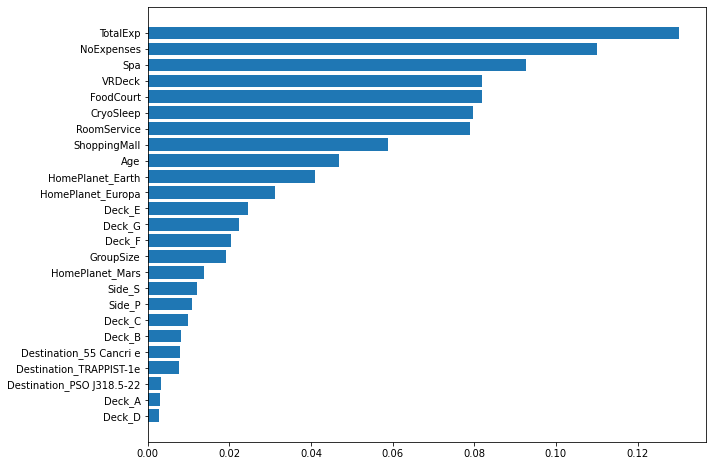

In [349]:
plt.figure(figsize=(10,8))
importances = grid_search_RF.best_estimator_.feature_importances_
names = grid_search_RF.best_estimator_.feature_names_in_
feat_importances = pd.DataFrame({"Name":names, "Importance":importances}).sort_values(by="Importance")
plt.barh(width=feat_importances.Importance, 
         y=feat_importances.Name)

In [219]:
names[importances<0.006]

array(['VIP', 'Alone', 'Destination_PSO J318.5-22', 'Deck_A', 'Deck_D',
       'Deck_T', 'Side_Missing'], dtype=object)

# AB

In [394]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

param_grid = { 
    'n_estimators':[200, 300, 400, 500, 900],
    'learning_rate':[0.2, 0.4, 0.5, 0.6, 0.7, 3]
}

AdaBoost = AdaBoostClassifier(random_state=123)
grid_search_AB = GridSearchCV(estimator=AdaBoost, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search_AB.fit(X, y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=123), n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.4, 0.5, 0.6, 0.7, 3],
                         'n_estimators': [200, 300, 400, 500, 900]},
             verbose=1)

In [395]:
grid_search_AB.best_estimator_

AdaBoostClassifier(learning_rate=0.5, n_estimators=200, random_state=123)

In [396]:
grid_search_AB.best_score_

0.7915569243067223

In [84]:
AB_pred = grid_search_AB.best_estimator_.predict(test)

AB_sub = test_raw[["PassengerId"]].copy()
AB_sub["Transported"] = AB_pred

AB_sub.to_csv("./spaceship-titanic/AB_cabin.csv", index=False)

## Logistic Regression

In [17]:
X, test, y = read_preprocess_titanic(cat_features=['HomePlanet', 'Destination', 'Deck', 'Side'],
                                     drop_features=['PassengerId', 'Name', 'GroupPos', 'CabinNum', 'GroupID'],
                                     bin_features={},
                                     one_hot=True)

# from feat imp, but got worse
X = X.drop(['VIP', 'Alone', 'Deck_T', 'Side_Missing'], axis=1)
test = test.drop(['VIP', 'Alone', 'Deck_T', 'Side_Missing'], axis=1)

In [14]:
from sklearn.preprocessing import StandardScaler

SC = StandardScaler().fit(X)
X = SC.transform(X)
test = SC.transform(test)

In [387]:
from sklearn.linear_model import LogisticRegression

params = {
    'penalty': ['l1','l2'], 
    'C': [0.001,0.01,0.1,1,8,10,15,100,1000]
}

LR = LogisticRegression(solver='liblinear')
LR_grid_search = GridSearchCV(estimator=LR, param_grid=params, cv=5, verbose=1, n_jobs=-1)
LR_grid_search.fit(X,y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 8, 10, 15, 100, 1000],
                         'penalty': ['l1', 'l2']},
             verbose=1)

In [391]:
LR_grid_search.best_estimator_

LogisticRegression(C=15, penalty='l1', solver='liblinear')

In [389]:
LR_grid_search.best_score_

0.7885663691750414

## Neural Net

In [122]:
!pip install wandb
!wandb login "8ecf7403a425fa8a096aeedbe252d23586e2a4cc"

wandb: Appending key for api.wandb.ai to your netrc file: /Users/patrickhiemsch/.netrc


In [44]:
import wandb
from wandb.keras import WandbCallback

In [24]:
import tensorflow as tf

In [25]:
tf.__version__

'2.8.0'

In [26]:
# check whether GPU can be accessed 
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [27]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.initializers import LecunNormal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler

In [28]:
# tf.keras.layers.Dropout(0.2)

In [230]:
X, test, y = read_preprocess_titanic(cat_features=['HomePlanet', 'Destination', 'Deck', 'Side'],
                                     drop_features=['PassengerId', 'Name', 'GroupPos', 'GroupID', 'CabinNum'],
                                     bin_features={},
                                     log_transform_exp=False,
                                     one_hot=True,
                                     drop_first_label=True)

# from feat imp, but got worse
#X = X.drop(['Deck_T', 'Side_Missing'], axis=1)
#test = test.drop(['Deck_T', 'Side_Missing'], axis=1)

# 'VIP', 'Alone',

X.CryoSleep = X.CryoSleep.astype(int)
X.VIP = X.VIP.astype(int)
X.Alone = X.Alone.astype(int)
X.NoExpenses = X.NoExpenses.astype(int)

test.CryoSleep = test.CryoSleep.astype(int)
test.VIP = test.VIP.astype(int)
test.Alone = test.Alone.astype(int)
test.NoExpenses = test.NoExpenses.astype(int)

SC = StandardScaler().fit(X)
X = SC.transform(X)
test = SC.transform(test)

In [30]:
i=105

In [203]:
# initialize run with hyperparameters 
batch_size = 32
epochs = 75
learning_rate = 0.001

i += 1

wandb.config = {
  "learning_rate": learning_rate,
  "epochs": epochs,
  "batch_size": batch_size
}

wandb.init(project="Spaceship-Titanic", 
           entity="patricksvm",
           config=wandb.config,
           name = f"Spaceship-Run-{i}")

accuracy,▁▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██▇███▇▇███████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▂▆▅▂▇▆▆▅▆▆▆▇▆█▇▆█▆▆▆▆▄▃▇▆▁▆▇▅▄▅▅▇█▇▆▅▅▆▅
val_loss,█▄▂▅▂▄▃▃▃▁▂▁▂▁▁▁▂▂▃▂▂▂▁▂▃▄▁▂▂▃▄▂▂▂▃▃▃▂▂▃
accuracy,0.81392
best_epoch,44
best_val_loss,0.39355
epoch,74
loss,0.38367
val_accuracy,0.79528


In [204]:
from numpy.random import seed
seed(123)
from tensorflow.random import set_seed
set_seed(123)

initializer = LecunNormal()

def lr_schedule(epoch):
    lrate = 0.0004
    if epoch > 10:
        lrate = 0.75*lrate
    if epoch > 20: #35 perf
        lrate = 0.5*lrate
    if epoch > 35: #35 perf
        lrate = 0.25*lrate
    if epoch > 50: #35 perf
        lrate = 0.1*lrate
    return lrate

model = Sequential([
  Dense(64, activation='selu'),
    Dropout(0.4),
    Dense(64, activation='selu'),
    Dropout(0.3),
    Dense(64, activation='selu'),
    Dropout(0.2),
    Dense(64, activation='selu'),
    Dense(16, activation='selu'),
  Dense(1, activation='sigmoid'),
])

# Patience is current best!!! not last
early_stop = EarlyStopping(monitor='val_accuracy', mode="max", patience=45, verbose=1, restore_best_weights=True)
opt_adam = Nadam(learning_rate=learning_rate) # Really good

model.compile(loss='binary_crossentropy', optimizer=opt_adam, metrics=['accuracy'])

history = model.fit(X, y, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2, callbacks=[
    early_stop, 
    WandbCallback()])
# LearningRateScheduler(lr_schedule)

Epoch 1/75


2022-08-08 17:04:47.703258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


218/218 [==============================] - ETA: 0s - loss: 0.5526 - accuracy: 0.7219

2022-08-08 17:04:52.407053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


218/218 [==============================] - 6s 21ms/step - loss: 0.5526 - accuracy: 0.7219 - val_loss: 0.4515 - val_accuracy: 0.7855 - _timestamp: 1659971092.0000 - _runtime: 8.0000
Epoch 2/75
218/218 [==============================] - 4s 18ms/step - loss: 0.4748 - accuracy: 0.7729 - val_loss: 0.4254 - val_accuracy: 0.7924 - _timestamp: 1659971096.0000 - _runtime: 12.0000
Epoch 3/75
218/218 [==============================] - 4s 19ms/step - loss: 0.4571 - accuracy: 0.7749 - val_loss: 0.4375 - val_accuracy: 0.7953 - _timestamp: 1659971100.0000 - _runtime: 16.0000
Epoch 4/75
218/218 [==============================] - 4s 18ms/step - loss: 0.4483 - accuracy: 0.7808 - val_loss: 0.4101 - val_accuracy: 0.7976 - _timestamp: 1659971104.0000 - _runtime: 20.0000
Epoch 5/75
218/218 [==============================] - 4s 18ms/step - loss: 0.4423 - accuracy: 0.7824 - val_loss: 0.4233 - val_accuracy: 0.7913 - _timestamp: 1659971108.0000 - _runtime: 24.0000
Epoch 6/75
218/218 [===========================

In [ ]:
# IMportant architecture fact: 256 16 a looot better

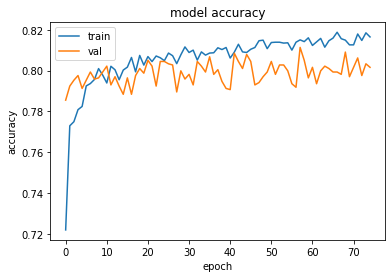

In [208]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [112]:
a = pd.read_csv("./spaceship-titanic/tomorrow.csv")
b = pd.read_csv("./spaceship-titanic/NN_first.csv")

In [197]:
#prediction = model.predict(test)
#prediction = list(map(lambda x: True if x >= 0.501 else False, prediction))
#print(np.sum(prediction)/len(prediction))

y.sum()/len(y)

0.5036236051995858

In [206]:
prediction = model.predict(test)
prediction = list(map(lambda x: True if x >= 0.5 else False, prediction))

2022-08-08 17:15:06.712975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [207]:
NN_pred = np.array(prediction)

NN_sub = test_raw[["PassengerId"]].copy()
NN_sub["Transported"] = NN_pred

NN_sub.to_csv(f"./spaceship-titanic/NN_tuned{i}.csv", index=False)

In [50]:
NN_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  4277 non-null   object
 1   Transported  4277 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 37.7+ KB


# XGBoost

In [142]:
! pip install xgboost

     |████████████████████████████████| 1.5 MB 2.9 MB/s eta 0:00:01


In [156]:
import xgboost as xgb

data = xgb.DMatrix(data=X,label=y)

params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'learning_rate': 0.1
}


xgb_class = xgb.cv(params=params, dtrain=data, nfold=5, metrics=("error"))

In [157]:
xgb_class

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.192684,0.003716,0.217530,0.006604
1,0.188600,0.004243,0.213388,0.008014
2,0.186213,0.003044,0.210054,0.004240
3,0.183539,0.002898,0.210282,0.008961
4,0.183280,0.002262,0.208557,0.006569
5,0.181209,0.001597,0.207867,0.006400
6,0.180576,0.001776,0.207867,0.007452
7,0.179052,0.001826,0.206832,0.007024
8,0.178707,0.001915,0.205567,0.007548
9,0.178563,0.001828,0.206257,0.006929


In [ ]:
#         'subsample': [0.6, 0.8, 1.0],

In [182]:
params = {
        'learning_rate': [0.1],
        'max_depth': [4, 5, 6, 8],
        'n_estimators': [50, 100, 200],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'subsample': [0.7, 0.8, 0.9]
        }

xgb_model = xgb.XGBClassifier(random_state=123, objective='binary:logistic')

xgb_grid = GridSearchCV(xgb_model, params, n_jobs=-1, cv=5, verbose=2, refit=True)
xgb_grid.fit(X,y)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=123, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8],
                         'learning_rate': [0.1], 'max_depth': [4, 5, 6, 8],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.7, 0.8, 0.9]},
             verbose=2)

In [186]:
xgb_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 100,
 'subsample': 0.8}

In [296]:
xgb_pred = xgb_grid.best_estimator_.predict(test)
xgb_pred = list(map(lambda x: True if x >= 0.5 else False, xgb_pred))

xgb_sub = test_raw[["PassengerId"]].copy()
xgb_sub["Transported"] = xgb_pred

xgb_sub.to_csv("./spaceship-titanic/xgb_first.csv", index=False)

NameError: name 'xgb_grid' is not defined

In [191]:
xgb_sub.Transported

0        True
1       False
2        True
3        True
4        True
        ...  
4272     True
4273    False
4274     True
4275     True
4276     True
Name: Transported, Length: 4277, dtype: bool

In [209]:
!pip install catboost

     |████████████████████████████████| 22.0 MB 8.0 MB/s eta 0:00:01          | 4.4 MB 2.9 MB/s eta 0:00:06��██████████████████████████  | 20.6 MB 8.8 MB/s eta 0:00:01
     |████████████████████████████████| 15.2 MB 7.9 MB/s eta 0:00:01�█████████████████▏         | 10.5 MB 7.0 MB/s eta 0:00:01  | 13.9 MB 7.0 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 8.2 MB/s  eta 0:00:01


In [21]:
X, test, y = read_preprocess_titanic(cat_features=['HomePlanet', 'Destination', 'Deck', 'Side', 'VIP', 'CryoSleep', 'NoExpenses'],
                                     drop_features=['PassengerId', 'Name', 'GroupPos', 'CabinNum', 'GroupID'],
                                     bin_features={},
                                     one_hot=True,
                                     label_encode=False,
                                     log_transform_exp=False)

# from feat imp, but got worse
#X = X.drop(['VIP', 'Alone'], axis=1)
#test = test.drop(['VIP', 'Alone'], axis=1)

In [278]:
y = y.map(lambda x: 1 if x else 0)

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [ ]:
       #       'learning_rate': [0.01, 0.025, 0.05, 0.08],
        #      'iterations': [10, 20, 30, 40, 50]

In [301]:
import catboost as cat


parameters = {'depth': [5,6,7,12,13]}

cat_model = cat.CatBoostClassifier(random_seed=123)

cat_grid = GridSearchCV(cat_model, parameters, n_jobs=-1, cv=5, verbose=1, refit=True, error_score='raise')
cat_grid.fit(X, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Learning rate set to 0.023581
0:	learn: 0.6838090	total: 58.5ms	remaining: 58.4s
1:	learn: 0.6735248	total: 61.4ms	remaining: 30.6s
2:	learn: 0.6638478	total: 63.6ms	remaining: 21.1s
3:	learn: 0.6542408	total: 65.7ms	remaining: 16.4s
4:	learn: 0.6455101	total: 68.4ms	remaining: 13.6s
5:	learn: 0.6373174	total: 70.8ms	remaining: 11.7s
6:	learn: 0.6303767	total: 73.3ms	remaining: 10.4s
7:	learn: 0.6224379	total: 76.2ms	remaining: 9.45s
8:	learn: 0.6151864	total: 78.6ms	remaining: 8.66s
9:	learn: 0.6083550	total: 81.9ms	remaining: 8.11s
10:	learn: 0.6020581	total: 85.4ms	remaining: 7.67s
11:	learn: 0.5959515	total: 89.4ms	remaining: 7.36s
12:	learn: 0.5899324	total: 91.3ms	remaining: 6.93s
13:	learn: 0.5849935	total: 96.3ms	remaining: 6.78s
14:	learn: 0.5802462	total: 98.2ms	remaining: 6.45s
15:	learn: 0.5749869	total: 100ms	remaining: 6.15s
16:	learn: 0.5708150	total: 102ms	remaining: 5.89s
17:	learn: 0.5656150	total: 104ms	rema

Learning rate set to 0.023583
0:	learn: 0.6827904	total: 59.8ms	remaining: 59.7s
1:	learn: 0.6738060	total: 63.6ms	remaining: 31.7s
2:	learn: 0.6636841	total: 65.5ms	remaining: 21.8s
3:	learn: 0.6538565	total: 69.3ms	remaining: 17.3s
4:	learn: 0.6447530	total: 73.9ms	remaining: 14.7s
5:	learn: 0.6361522	total: 78.2ms	remaining: 13s
6:	learn: 0.6291097	total: 82.6ms	remaining: 11.7s
7:	learn: 0.6213193	total: 87.3ms	remaining: 10.8s
8:	learn: 0.6140255	total: 91.1ms	remaining: 10s
9:	learn: 0.6073653	total: 114ms	remaining: 11.3s
10:	learn: 0.6004737	total: 118ms	remaining: 10.6s
11:	learn: 0.5944854	total: 120ms	remaining: 9.9s
12:	learn: 0.5881683	total: 122ms	remaining: 9.27s
13:	learn: 0.5831967	total: 124ms	remaining: 8.74s
14:	learn: 0.5776181	total: 126ms	remaining: 8.27s
15:	learn: 0.5722486	total: 128ms	remaining: 7.87s
16:	learn: 0.5685823	total: 132ms	remaining: 7.62s
17:	learn: 0.5642327	total: 135ms	remaining: 7.38s
18:	learn: 0.5595203	total: 139ms	remaining: 7.19s
19:	lea

Learning rate set to 0.023581
0:	learn: 0.6817091	total: 59.1ms	remaining: 59s
1:	learn: 0.6708038	total: 61.3ms	remaining: 30.6s
2:	learn: 0.6608600	total: 63.4ms	remaining: 21.1s
3:	learn: 0.6520463	total: 66ms	remaining: 16.4s
4:	learn: 0.6427101	total: 68.2ms	remaining: 13.6s
5:	learn: 0.6341635	total: 70.3ms	remaining: 11.6s
6:	learn: 0.6266718	total: 72.3ms	remaining: 10.3s
7:	learn: 0.6187997	total: 75.1ms	remaining: 9.31s
8:	learn: 0.6116064	total: 77.4ms	remaining: 8.52s
9:	learn: 0.6049640	total: 80.1ms	remaining: 7.92s
10:	learn: 0.5994406	total: 82.6ms	remaining: 7.43s
11:	learn: 0.5935267	total: 85.8ms	remaining: 7.07s
12:	learn: 0.5873744	total: 88ms	remaining: 6.68s
13:	learn: 0.5817955	total: 90.6ms	remaining: 6.38s
14:	learn: 0.5771904	total: 93.8ms	remaining: 6.16s
15:	learn: 0.5717431	total: 95.7ms	remaining: 5.88s
16:	learn: 0.5678614	total: 97.6ms	remaining: 5.64s
17:	learn: 0.5635582	total: 102ms	remaining: 5.57s
18:	learn: 0.5588977	total: 108ms	remaining: 5.58s


502:	learn: 0.3705045	total: 1.64s	remaining: 1.62s
503:	learn: 0.3703707	total: 1.64s	remaining: 1.61s
504:	learn: 0.3702794	total: 1.65s	remaining: 1.61s
505:	learn: 0.3701258	total: 1.65s	remaining: 1.61s
506:	learn: 0.3699922	total: 1.65s	remaining: 1.61s
507:	learn: 0.3698958	total: 1.66s	remaining: 1.6s
508:	learn: 0.3697907	total: 1.66s	remaining: 1.6s
509:	learn: 0.3697001	total: 1.66s	remaining: 1.59s
510:	learn: 0.3695970	total: 1.66s	remaining: 1.59s
511:	learn: 0.3695311	total: 1.66s	remaining: 1.58s
512:	learn: 0.3694688	total: 1.67s	remaining: 1.58s
513:	learn: 0.3692801	total: 1.67s	remaining: 1.58s
514:	learn: 0.3691941	total: 1.67s	remaining: 1.58s
515:	learn: 0.3691234	total: 1.68s	remaining: 1.57s
516:	learn: 0.3689856	total: 1.68s	remaining: 1.57s
517:	learn: 0.3688745	total: 1.68s	remaining: 1.57s
518:	learn: 0.3688182	total: 1.69s	remaining: 1.56s
519:	learn: 0.3687068	total: 1.69s	remaining: 1.56s
520:	learn: 0.3685795	total: 1.7s	remaining: 1.56s
521:	learn: 0.3

676:	learn: 0.3538876	total: 2.24s	remaining: 1.07s
677:	learn: 0.3538288	total: 2.24s	remaining: 1.06s
678:	learn: 0.3537496	total: 2.25s	remaining: 1.06s
679:	learn: 0.3536462	total: 2.25s	remaining: 1.06s
680:	learn: 0.3535944	total: 2.26s	remaining: 1.06s
681:	learn: 0.3535029	total: 2.26s	remaining: 1.05s
682:	learn: 0.3534397	total: 2.27s	remaining: 1.05s
683:	learn: 0.3533388	total: 2.27s	remaining: 1.05s
684:	learn: 0.3532370	total: 2.27s	remaining: 1.04s
685:	learn: 0.3531292	total: 2.27s	remaining: 1.04s
686:	learn: 0.3530363	total: 2.28s	remaining: 1.04s
687:	learn: 0.3529619	total: 2.28s	remaining: 1.03s
688:	learn: 0.3528719	total: 2.29s	remaining: 1.03s
689:	learn: 0.3527855	total: 2.31s	remaining: 1.04s
690:	learn: 0.3527270	total: 2.32s	remaining: 1.04s
691:	learn: 0.3526592	total: 2.33s	remaining: 1.03s
692:	learn: 0.3525060	total: 2.33s	remaining: 1.03s
693:	learn: 0.3524369	total: 2.33s	remaining: 1.03s
694:	learn: 0.3523205	total: 2.34s	remaining: 1.02s
695:	learn: 

958:	learn: 0.3035669	total: 3.58s	remaining: 153ms
959:	learn: 0.3034517	total: 3.58s	remaining: 149ms
960:	learn: 0.3033731	total: 3.58s	remaining: 145ms
961:	learn: 0.3032752	total: 3.59s	remaining: 142ms
962:	learn: 0.3031997	total: 3.59s	remaining: 138ms
963:	learn: 0.3031468	total: 3.59s	remaining: 134ms
964:	learn: 0.3031036	total: 3.6s	remaining: 130ms
965:	learn: 0.3030509	total: 3.6s	remaining: 127ms
966:	learn: 0.3029486	total: 3.6s	remaining: 123ms
967:	learn: 0.3029048	total: 3.6s	remaining: 119ms
968:	learn: 0.3027845	total: 3.6s	remaining: 115ms
969:	learn: 0.3027274	total: 3.61s	remaining: 112ms
970:	learn: 0.3026705	total: 3.62s	remaining: 108ms
971:	learn: 0.3025777	total: 3.62s	remaining: 104ms
972:	learn: 0.3025226	total: 3.63s	remaining: 101ms
973:	learn: 0.3024592	total: 3.63s	remaining: 96.9ms
974:	learn: 0.3024200	total: 3.63s	remaining: 93.1ms
975:	learn: 0.3023284	total: 3.63s	remaining: 89.4ms
976:	learn: 0.3022411	total: 3.63s	remaining: 85.6ms
977:	learn: 0

Learning rate set to 0.023581
0:	learn: 0.6816277	total: 58.8ms	remaining: 58.7s
1:	learn: 0.6707196	total: 61.8ms	remaining: 30.8s
2:	learn: 0.6595248	total: 64.6ms	remaining: 21.5s
3:	learn: 0.6483158	total: 67.1ms	remaining: 16.7s
4:	learn: 0.6384926	total: 71.4ms	remaining: 14.2s
5:	learn: 0.6296051	total: 79.5ms	remaining: 13.2s
6:	learn: 0.6210959	total: 81.8ms	remaining: 11.6s
7:	learn: 0.6130711	total: 84.1ms	remaining: 10.4s
8:	learn: 0.6049183	total: 86.4ms	remaining: 9.51s
9:	learn: 0.5989475	total: 88.8ms	remaining: 8.79s
10:	learn: 0.5933477	total: 92.3ms	remaining: 8.3s
11:	learn: 0.5862476	total: 98.1ms	remaining: 8.07s
12:	learn: 0.5794036	total: 104ms	remaining: 7.87s
13:	learn: 0.5749186	total: 110ms	remaining: 7.73s
14:	learn: 0.5705585	total: 114ms	remaining: 7.49s
15:	learn: 0.5649776	total: 116ms	remaining: 7.16s
16:	learn: 0.5596678	total: 119ms	remaining: 6.86s
17:	learn: 0.5546872	total: 121ms	remaining: 6.6s
18:	learn: 0.5492933	total: 123ms	remaining: 6.37s
1

263:	learn: 0.3882552	total: 1s	remaining: 2.79s
264:	learn: 0.3881652	total: 1.01s	remaining: 2.79s
265:	learn: 0.3880189	total: 1.01s	remaining: 2.79s
266:	learn: 0.3879135	total: 1.02s	remaining: 2.79s
267:	learn: 0.3876306	total: 1.02s	remaining: 2.79s
268:	learn: 0.3874860	total: 1.03s	remaining: 2.79s
269:	learn: 0.3873005	total: 1.03s	remaining: 2.78s
270:	learn: 0.3872391	total: 1.03s	remaining: 2.78s
271:	learn: 0.3870483	total: 1.04s	remaining: 2.79s
272:	learn: 0.3868862	total: 1.04s	remaining: 2.78s
273:	learn: 0.3867921	total: 1.05s	remaining: 2.77s
274:	learn: 0.3867088	total: 1.05s	remaining: 2.77s
275:	learn: 0.3865890	total: 1.05s	remaining: 2.76s
276:	learn: 0.3865229	total: 1.06s	remaining: 2.77s
277:	learn: 0.3864331	total: 1.06s	remaining: 2.76s
278:	learn: 0.3863134	total: 1.07s	remaining: 2.76s
279:	learn: 0.3860992	total: 1.09s	remaining: 2.82s
280:	learn: 0.3859747	total: 1.1s	remaining: 2.82s
281:	learn: 0.3855290	total: 1.1s	remaining: 2.81s
282:	learn: 0.385

900:	learn: 0.3159515	total: 4.52s	remaining: 497ms
901:	learn: 0.3158633	total: 4.53s	remaining: 492ms
902:	learn: 0.3157670	total: 4.53s	remaining: 487ms
903:	learn: 0.3157273	total: 4.53s	remaining: 481ms
904:	learn: 0.3156100	total: 4.54s	remaining: 476ms
905:	learn: 0.3155456	total: 4.54s	remaining: 471ms
906:	learn: 0.3154365	total: 4.54s	remaining: 466ms
907:	learn: 0.3153310	total: 4.56s	remaining: 462ms
908:	learn: 0.3152302	total: 4.58s	remaining: 459ms
909:	learn: 0.3151472	total: 4.59s	remaining: 454ms
910:	learn: 0.3150324	total: 4.59s	remaining: 449ms
911:	learn: 0.3149639	total: 4.6s	remaining: 444ms
912:	learn: 0.3148798	total: 4.6s	remaining: 439ms
913:	learn: 0.3148406	total: 4.61s	remaining: 434ms
914:	learn: 0.3147589	total: 4.63s	remaining: 430ms
915:	learn: 0.3146321	total: 4.63s	remaining: 425ms
916:	learn: 0.3143719	total: 4.64s	remaining: 420ms
917:	learn: 0.3143109	total: 4.64s	remaining: 415ms
918:	learn: 0.3142475	total: 4.66s	remaining: 410ms
919:	learn: 0.

262:	learn: 0.3905821	total: 1.09s	remaining: 3.05s
263:	learn: 0.3904768	total: 1.09s	remaining: 3.04s
264:	learn: 0.3903743	total: 1.09s	remaining: 3.04s
265:	learn: 0.3902546	total: 1.1s	remaining: 3.03s
266:	learn: 0.3900559	total: 1.1s	remaining: 3.03s
267:	learn: 0.3899350	total: 1.1s	remaining: 3.02s
268:	learn: 0.3897877	total: 1.11s	remaining: 3.02s
269:	learn: 0.3896551	total: 1.12s	remaining: 3.03s
270:	learn: 0.3894457	total: 1.12s	remaining: 3.02s
271:	learn: 0.3893199	total: 1.13s	remaining: 3.02s
272:	learn: 0.3892150	total: 1.13s	remaining: 3.01s
273:	learn: 0.3889499	total: 1.13s	remaining: 3s
274:	learn: 0.3888448	total: 1.14s	remaining: 3s
275:	learn: 0.3887149	total: 1.14s	remaining: 2.99s
276:	learn: 0.3884647	total: 1.14s	remaining: 2.98s
277:	learn: 0.3883165	total: 1.15s	remaining: 2.98s
278:	learn: 0.3882189	total: 1.15s	remaining: 2.97s
279:	learn: 0.3881063	total: 1.15s	remaining: 2.96s
280:	learn: 0.3879162	total: 1.16s	remaining: 2.96s
281:	learn: 0.3877457

474:	learn: 0.3610355	total: 2.08s	remaining: 2.31s
475:	learn: 0.3609349	total: 2.09s	remaining: 2.3s
476:	learn: 0.3608176	total: 2.1s	remaining: 2.3s
477:	learn: 0.3607246	total: 2.11s	remaining: 2.3s
478:	learn: 0.3605980	total: 2.11s	remaining: 2.29s
479:	learn: 0.3604141	total: 2.12s	remaining: 2.29s
480:	learn: 0.3603025	total: 2.12s	remaining: 2.29s
481:	learn: 0.3601832	total: 2.14s	remaining: 2.3s
482:	learn: 0.3600062	total: 2.14s	remaining: 2.29s
483:	learn: 0.3597545	total: 2.15s	remaining: 2.29s
484:	learn: 0.3596766	total: 2.17s	remaining: 2.3s
485:	learn: 0.3594829	total: 2.17s	remaining: 2.29s
486:	learn: 0.3593367	total: 2.17s	remaining: 2.29s
487:	learn: 0.3592023	total: 2.18s	remaining: 2.29s
488:	learn: 0.3590207	total: 2.18s	remaining: 2.28s
489:	learn: 0.3589046	total: 2.2s	remaining: 2.29s
490:	learn: 0.3587395	total: 2.21s	remaining: 2.29s
491:	learn: 0.3586260	total: 2.21s	remaining: 2.28s
492:	learn: 0.3585429	total: 2.21s	remaining: 2.27s
493:	learn: 0.35835

111:	learn: 0.3517496	total: 10s	remaining: 1m 19s
112:	learn: 0.3512920	total: 10.1s	remaining: 1m 19s
113:	learn: 0.3508073	total: 10.3s	remaining: 1m 19s
114:	learn: 0.3506793	total: 10.3s	remaining: 1m 18s
115:	learn: 0.3502664	total: 10.4s	remaining: 1m 19s
116:	learn: 0.3499899	total: 10.4s	remaining: 1m 18s
117:	learn: 0.3492619	total: 10.5s	remaining: 1m 18s
118:	learn: 0.3487549	total: 10.6s	remaining: 1m 18s
119:	learn: 0.3482986	total: 10.7s	remaining: 1m 18s
120:	learn: 0.3479749	total: 10.9s	remaining: 1m 18s
121:	learn: 0.3473692	total: 10.9s	remaining: 1m 18s
122:	learn: 0.3467583	total: 11.1s	remaining: 1m 18s
123:	learn: 0.3463107	total: 11.2s	remaining: 1m 19s
124:	learn: 0.3456484	total: 11.3s	remaining: 1m 18s
125:	learn: 0.3448755	total: 11.4s	remaining: 1m 18s
126:	learn: 0.3442044	total: 11.4s	remaining: 1m 18s
127:	learn: 0.3437074	total: 11.5s	remaining: 1m 18s
128:	learn: 0.3432997	total: 11.6s	remaining: 1m 18s
129:	learn: 0.3426637	total: 11.7s	remaining: 1m

882:	learn: 0.2849816	total: 6.44s	remaining: 853ms
883:	learn: 0.2849618	total: 6.44s	remaining: 845ms
884:	learn: 0.2848427	total: 6.44s	remaining: 837ms
885:	learn: 0.2848037	total: 6.45s	remaining: 830ms
886:	learn: 0.2846525	total: 6.45s	remaining: 822ms
887:	learn: 0.2845643	total: 6.46s	remaining: 814ms
888:	learn: 0.2844703	total: 6.46s	remaining: 807ms
889:	learn: 0.2843628	total: 6.47s	remaining: 799ms
890:	learn: 0.2842947	total: 6.47s	remaining: 792ms
891:	learn: 0.2842315	total: 6.48s	remaining: 784ms
892:	learn: 0.2841101	total: 6.48s	remaining: 777ms
893:	learn: 0.2840387	total: 6.49s	remaining: 769ms
894:	learn: 0.2839711	total: 6.49s	remaining: 762ms
895:	learn: 0.2838830	total: 6.49s	remaining: 754ms
896:	learn: 0.2838004	total: 6.53s	remaining: 750ms
897:	learn: 0.2837045	total: 6.53s	remaining: 742ms
898:	learn: 0.2836558	total: 6.58s	remaining: 739ms
899:	learn: 0.2835813	total: 6.58s	remaining: 732ms
900:	learn: 0.2834978	total: 6.59s	remaining: 724ms
901:	learn: 

263:	learn: 0.3735093	total: 1.62s	remaining: 4.53s
264:	learn: 0.3733343	total: 1.63s	remaining: 4.51s
265:	learn: 0.3731905	total: 1.63s	remaining: 4.5s
266:	learn: 0.3730230	total: 1.63s	remaining: 4.48s
267:	learn: 0.3728637	total: 1.65s	remaining: 4.5s
268:	learn: 0.3726624	total: 1.66s	remaining: 4.5s
269:	learn: 0.3725381	total: 1.67s	remaining: 4.5s
270:	learn: 0.3722820	total: 1.67s	remaining: 4.49s
271:	learn: 0.3722058	total: 1.67s	remaining: 4.47s
272:	learn: 0.3720297	total: 1.68s	remaining: 4.46s
273:	learn: 0.3718645	total: 1.68s	remaining: 4.45s
274:	learn: 0.3716677	total: 1.69s	remaining: 4.45s
275:	learn: 0.3715410	total: 1.69s	remaining: 4.44s
276:	learn: 0.3714542	total: 1.7s	remaining: 4.43s
277:	learn: 0.3712661	total: 1.7s	remaining: 4.42s
278:	learn: 0.3711246	total: 1.7s	remaining: 4.4s
279:	learn: 0.3709252	total: 1.72s	remaining: 4.41s
280:	learn: 0.3707608	total: 1.73s	remaining: 4.42s
281:	learn: 0.3706045	total: 1.75s	remaining: 4.44s
282:	learn: 0.370473

494:	learn: 0.2207126	total: 50.2s	remaining: 51.2s
495:	learn: 0.2204533	total: 50.3s	remaining: 51.1s
496:	learn: 0.2203344	total: 50.5s	remaining: 51.1s
497:	learn: 0.2202367	total: 50.6s	remaining: 51s
498:	learn: 0.2200161	total: 50.6s	remaining: 50.8s
499:	learn: 0.2198148	total: 50.7s	remaining: 50.7s
500:	learn: 0.2196735	total: 50.9s	remaining: 50.7s
501:	learn: 0.2195083	total: 50.9s	remaining: 50.5s
502:	learn: 0.2192858	total: 51s	remaining: 50.4s
503:	learn: 0.2191350	total: 51.2s	remaining: 50.4s
504:	learn: 0.2189148	total: 51.3s	remaining: 50.2s
505:	learn: 0.2187036	total: 51.3s	remaining: 50.1s
506:	learn: 0.2185361	total: 51.4s	remaining: 50s
507:	learn: 0.2184120	total: 51.5s	remaining: 49.9s
508:	learn: 0.2181475	total: 51.6s	remaining: 49.8s
509:	learn: 0.2180052	total: 51.8s	remaining: 49.7s
510:	learn: 0.2178870	total: 51.9s	remaining: 49.6s
511:	learn: 0.2176612	total: 52s	remaining: 49.5s
512:	learn: 0.2174625	total: 52.1s	remaining: 49.5s
513:	learn: 0.217200

/Users/patrickhiemsch/miniforge3/envs/TF_M1/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


526:	learn: 0.2078168	total: 51.4s	remaining: 46.2s
527:	learn: 0.2076975	total: 51.6s	remaining: 46.1s
528:	learn: 0.2076294	total: 51.7s	remaining: 46s
529:	learn: 0.2074362	total: 51.8s	remaining: 45.9s
530:	learn: 0.2072288	total: 51.9s	remaining: 45.8s
531:	learn: 0.2071319	total: 52s	remaining: 45.8s
532:	learn: 0.2066853	total: 52.1s	remaining: 45.7s
533:	learn: 0.2064666	total: 52.2s	remaining: 45.6s
534:	learn: 0.2062401	total: 52.3s	remaining: 45.5s
535:	learn: 0.2061577	total: 52.4s	remaining: 45.4s
536:	learn: 0.2060745	total: 52.5s	remaining: 45.3s
537:	learn: 0.2059283	total: 52.7s	remaining: 45.2s
538:	learn: 0.2056602	total: 52.7s	remaining: 45.1s
539:	learn: 0.2055275	total: 52.8s	remaining: 45s
540:	learn: 0.2053890	total: 53s	remaining: 45s
541:	learn: 0.2051682	total: 53.1s	remaining: 44.9s
542:	learn: 0.2049191	total: 53.2s	remaining: 44.8s
543:	learn: 0.2047849	total: 53.3s	remaining: 44.7s
544:	learn: 0.2044745	total: 53.4s	remaining: 44.6s
545:	learn: 0.2040549	

630:	learn: 0.3110492	total: 4.47s	remaining: 2.61s
631:	learn: 0.3109164	total: 4.47s	remaining: 2.6s
632:	learn: 0.3108109	total: 4.48s	remaining: 2.6s
633:	learn: 0.3107317	total: 4.48s	remaining: 2.59s
634:	learn: 0.3105649	total: 4.49s	remaining: 2.58s
635:	learn: 0.3104559	total: 4.5s	remaining: 2.57s
636:	learn: 0.3103045	total: 4.5s	remaining: 2.57s
637:	learn: 0.3101632	total: 4.51s	remaining: 2.56s
638:	learn: 0.3100777	total: 4.52s	remaining: 2.55s
639:	learn: 0.3099685	total: 4.52s	remaining: 2.54s
640:	learn: 0.3098389	total: 4.52s	remaining: 2.53s
641:	learn: 0.3097551	total: 4.53s	remaining: 2.52s
642:	learn: 0.3096333	total: 4.53s	remaining: 2.52s
643:	learn: 0.3095821	total: 4.54s	remaining: 2.51s
644:	learn: 0.3094156	total: 4.54s	remaining: 2.5s
645:	learn: 0.3092746	total: 4.55s	remaining: 2.49s
646:	learn: 0.3091443	total: 4.56s	remaining: 2.49s
647:	learn: 0.3090268	total: 4.57s	remaining: 2.48s
648:	learn: 0.3088889	total: 4.58s	remaining: 2.48s
649:	learn: 0.308

55:	learn: 0.3960023	total: 8.19s	remaining: 2m 18s
56:	learn: 0.3949080	total: 8.38s	remaining: 2m 18s
57:	learn: 0.3929844	total: 8.56s	remaining: 2m 18s
58:	learn: 0.3914192	total: 8.74s	remaining: 2m 19s
59:	learn: 0.3899538	total: 8.89s	remaining: 2m 19s
60:	learn: 0.3876830	total: 9.1s	remaining: 2m 20s
61:	learn: 0.3855836	total: 9.23s	remaining: 2m 19s
62:	learn: 0.3832379	total: 9.37s	remaining: 2m 19s
63:	learn: 0.3818192	total: 9.5s	remaining: 2m 19s
64:	learn: 0.3807950	total: 9.61s	remaining: 2m 18s
65:	learn: 0.3788512	total: 9.78s	remaining: 2m 18s
66:	learn: 0.3775100	total: 9.99s	remaining: 2m 19s
67:	learn: 0.3754222	total: 10.2s	remaining: 2m 19s
68:	learn: 0.3741650	total: 10.3s	remaining: 2m 18s
69:	learn: 0.3729841	total: 10.4s	remaining: 2m 18s
70:	learn: 0.3713290	total: 10.5s	remaining: 2m 17s
71:	learn: 0.3698264	total: 10.7s	remaining: 2m 17s
72:	learn: 0.3678964	total: 10.9s	remaining: 2m 18s
73:	learn: 0.3666890	total: 11s	remaining: 2m 17s
74:	learn: 0.365

492:	learn: 0.1995320	total: 1m 11s	remaining: 1m 13s
493:	learn: 0.1993039	total: 1m 11s	remaining: 1m 13s
494:	learn: 0.1991082	total: 1m 11s	remaining: 1m 13s
495:	learn: 0.1988879	total: 1m 11s	remaining: 1m 13s
496:	learn: 0.1987695	total: 1m 11s	remaining: 1m 12s
497:	learn: 0.1986479	total: 1m 12s	remaining: 1m 12s
498:	learn: 0.1984890	total: 1m 12s	remaining: 1m 12s
499:	learn: 0.1983574	total: 1m 12s	remaining: 1m 12s
500:	learn: 0.1979833	total: 1m 12s	remaining: 1m 12s
501:	learn: 0.1977220	total: 1m 12s	remaining: 1m 11s
502:	learn: 0.1974417	total: 1m 12s	remaining: 1m 11s
503:	learn: 0.1970507	total: 1m 12s	remaining: 1m 11s
504:	learn: 0.1968585	total: 1m 12s	remaining: 1m 11s
505:	learn: 0.1966368	total: 1m 13s	remaining: 1m 11s
506:	learn: 0.1965080	total: 1m 13s	remaining: 1m 11s
507:	learn: 0.1962961	total: 1m 13s	remaining: 1m 10s
508:	learn: 0.1961971	total: 1m 13s	remaining: 1m 10s
509:	learn: 0.1960385	total: 1m 13s	remaining: 1m 10s
510:	learn: 0.1959311	total:

718:	learn: 0.1890605	total: 1m 11s	remaining: 27.9s
719:	learn: 0.1888153	total: 1m 11s	remaining: 27.8s
720:	learn: 0.1886636	total: 1m 11s	remaining: 27.7s
721:	learn: 0.1884969	total: 1m 11s	remaining: 27.6s
722:	learn: 0.1882708	total: 1m 11s	remaining: 27.5s
723:	learn: 0.1881207	total: 1m 11s	remaining: 27.4s
724:	learn: 0.1879282	total: 1m 11s	remaining: 27.3s
725:	learn: 0.1877707	total: 1m 12s	remaining: 27.2s
726:	learn: 0.1876618	total: 1m 12s	remaining: 27.1s
727:	learn: 0.1874503	total: 1m 12s	remaining: 27s
728:	learn: 0.1873000	total: 1m 12s	remaining: 26.9s
729:	learn: 0.1872093	total: 1m 12s	remaining: 26.8s
730:	learn: 0.1871338	total: 1m 12s	remaining: 26.7s
731:	learn: 0.1869782	total: 1m 12s	remaining: 26.6s
732:	learn: 0.1868857	total: 1m 12s	remaining: 26.5s
733:	learn: 0.1866999	total: 1m 12s	remaining: 26.4s
734:	learn: 0.1864503	total: 1m 12s	remaining: 26.3s
735:	learn: 0.1861851	total: 1m 12s	remaining: 26.2s
736:	learn: 0.1859513	total: 1m 13s	remaining: 2

264:	learn: 0.3757567	total: 1.99s	remaining: 5.52s
265:	learn: 0.3756028	total: 1.99s	remaining: 5.5s
266:	learn: 0.3752814	total: 2s	remaining: 5.49s
267:	learn: 0.3752081	total: 2s	remaining: 5.47s
268:	learn: 0.3750725	total: 2s	remaining: 5.45s
269:	learn: 0.3749196	total: 2.01s	remaining: 5.44s
270:	learn: 0.3746047	total: 2.02s	remaining: 5.44s
271:	learn: 0.3742577	total: 2.03s	remaining: 5.43s
272:	learn: 0.3740386	total: 2.03s	remaining: 5.42s
273:	learn: 0.3739209	total: 2.04s	remaining: 5.4s
274:	learn: 0.3735442	total: 2.05s	remaining: 5.41s
275:	learn: 0.3733708	total: 2.06s	remaining: 5.39s
276:	learn: 0.3732393	total: 2.06s	remaining: 5.38s
277:	learn: 0.3730535	total: 2.06s	remaining: 5.36s
278:	learn: 0.3727959	total: 2.06s	remaining: 5.34s
279:	learn: 0.3726940	total: 2.07s	remaining: 5.32s
280:	learn: 0.3725494	total: 2.07s	remaining: 5.3s
281:	learn: 0.3724096	total: 2.08s	remaining: 5.29s
282:	learn: 0.3722685	total: 2.08s	remaining: 5.28s
283:	learn: 0.3720518	to

805:	learn: 0.2969407	total: 6.64s	remaining: 1.6s
806:	learn: 0.2967889	total: 6.67s	remaining: 1.6s
807:	learn: 0.2967149	total: 6.68s	remaining: 1.59s
808:	learn: 0.2966364	total: 6.69s	remaining: 1.58s
809:	learn: 0.2965808	total: 6.7s	remaining: 1.57s
810:	learn: 0.2963976	total: 6.7s	remaining: 1.56s
811:	learn: 0.2963039	total: 6.74s	remaining: 1.56s
812:	learn: 0.2961583	total: 6.75s	remaining: 1.55s
813:	learn: 0.2960586	total: 6.76s	remaining: 1.54s
814:	learn: 0.2959872	total: 6.77s	remaining: 1.54s
815:	learn: 0.2958349	total: 6.78s	remaining: 1.53s
816:	learn: 0.2957089	total: 6.78s	remaining: 1.52s
817:	learn: 0.2956525	total: 6.82s	remaining: 1.52s
818:	learn: 0.2955690	total: 6.86s	remaining: 1.52s
819:	learn: 0.2955144	total: 6.87s	remaining: 1.51s
820:	learn: 0.2954494	total: 6.87s	remaining: 1.5s
821:	learn: 0.2953846	total: 6.88s	remaining: 1.49s
822:	learn: 0.2952410	total: 6.88s	remaining: 1.48s
823:	learn: 0.2950197	total: 6.88s	remaining: 1.47s
824:	learn: 0.294

522:	learn: 0.2150140	total: 53.3s	remaining: 48.6s
523:	learn: 0.2149117	total: 53.5s	remaining: 48.6s
524:	learn: 0.2147117	total: 53.6s	remaining: 48.5s
525:	learn: 0.2144651	total: 53.7s	remaining: 48.4s
526:	learn: 0.2141924	total: 53.8s	remaining: 48.3s
527:	learn: 0.2140463	total: 53.9s	remaining: 48.2s
528:	learn: 0.2139408	total: 54s	remaining: 48.1s
529:	learn: 0.2136926	total: 54.1s	remaining: 48s
530:	learn: 0.2136255	total: 54.2s	remaining: 47.9s
531:	learn: 0.2134786	total: 54.3s	remaining: 47.8s
532:	learn: 0.2134135	total: 54.4s	remaining: 47.7s
533:	learn: 0.2132855	total: 54.5s	remaining: 47.6s
534:	learn: 0.2131465	total: 54.6s	remaining: 47.5s
535:	learn: 0.2130539	total: 54.8s	remaining: 47.4s
536:	learn: 0.2128761	total: 55s	remaining: 47.4s
537:	learn: 0.2125946	total: 55.1s	remaining: 47.3s
538:	learn: 0.2124724	total: 55.3s	remaining: 47.3s
539:	learn: 0.2123228	total: 55.4s	remaining: 47.2s
540:	learn: 0.2121908	total: 55.6s	remaining: 47.1s
541:	learn: 0.2119

772:	learn: 0.1740156	total: 1m 18s	remaining: 23s
773:	learn: 0.1738113	total: 1m 18s	remaining: 22.9s
774:	learn: 0.1736123	total: 1m 18s	remaining: 22.8s
775:	learn: 0.1734752	total: 1m 18s	remaining: 22.7s
776:	learn: 0.1733882	total: 1m 18s	remaining: 22.6s
777:	learn: 0.1732312	total: 1m 18s	remaining: 22.5s
778:	learn: 0.1730634	total: 1m 19s	remaining: 22.4s
779:	learn: 0.1729139	total: 1m 19s	remaining: 22.3s
780:	learn: 0.1727201	total: 1m 19s	remaining: 22.2s
781:	learn: 0.1725960	total: 1m 19s	remaining: 22.1s
782:	learn: 0.1724482	total: 1m 19s	remaining: 22s
783:	learn: 0.1723251	total: 1m 19s	remaining: 21.9s
784:	learn: 0.1722539	total: 1m 19s	remaining: 21.8s
785:	learn: 0.1721322	total: 1m 19s	remaining: 21.8s
786:	learn: 0.1719795	total: 1m 19s	remaining: 21.6s
787:	learn: 0.1719262	total: 1m 20s	remaining: 21.5s
788:	learn: 0.1718695	total: 1m 20s	remaining: 21.4s
789:	learn: 0.1717270	total: 1m 20s	remaining: 21.3s
790:	learn: 0.1715611	total: 1m 20s	remaining: 21.

518:	learn: 0.1944916	total: 1m 14s	remaining: 1m 9s
519:	learn: 0.1942663	total: 1m 14s	remaining: 1m 9s
520:	learn: 0.1941177	total: 1m 14s	remaining: 1m 8s
521:	learn: 0.1938581	total: 1m 15s	remaining: 1m 8s
522:	learn: 0.1937377	total: 1m 15s	remaining: 1m 8s
523:	learn: 0.1935551	total: 1m 15s	remaining: 1m 8s
524:	learn: 0.1934051	total: 1m 15s	remaining: 1m 8s
525:	learn: 0.1932632	total: 1m 15s	remaining: 1m 8s
526:	learn: 0.1931947	total: 1m 15s	remaining: 1m 8s
527:	learn: 0.1930874	total: 1m 16s	remaining: 1m 8s
528:	learn: 0.1927972	total: 1m 16s	remaining: 1m 7s
529:	learn: 0.1926830	total: 1m 16s	remaining: 1m 7s
530:	learn: 0.1925775	total: 1m 16s	remaining: 1m 7s
531:	learn: 0.1924635	total: 1m 16s	remaining: 1m 7s
532:	learn: 0.1923747	total: 1m 16s	remaining: 1m 7s
533:	learn: 0.1922684	total: 1m 16s	remaining: 1m 7s
534:	learn: 0.1920604	total: 1m 16s	remaining: 1m 6s
535:	learn: 0.1917500	total: 1m 17s	remaining: 1m 6s
536:	learn: 0.1916462	total: 1m 17s	remaining:

519:	learn: 0.2023263	total: 1m 14s	remaining: 1m 8s
520:	learn: 0.2021456	total: 1m 14s	remaining: 1m 8s
521:	learn: 0.2020184	total: 1m 14s	remaining: 1m 8s
522:	learn: 0.2017532	total: 1m 14s	remaining: 1m 8s
523:	learn: 0.2016067	total: 1m 14s	remaining: 1m 7s
524:	learn: 0.2015259	total: 1m 15s	remaining: 1m 7s
525:	learn: 0.2013245	total: 1m 15s	remaining: 1m 7s
526:	learn: 0.2011547	total: 1m 15s	remaining: 1m 7s
527:	learn: 0.2009865	total: 1m 15s	remaining: 1m 7s
528:	learn: 0.2008746	total: 1m 15s	remaining: 1m 7s
529:	learn: 0.2007816	total: 1m 15s	remaining: 1m 7s
530:	learn: 0.2005676	total: 1m 15s	remaining: 1m 7s
531:	learn: 0.2003619	total: 1m 16s	remaining: 1m 6s
532:	learn: 0.2001524	total: 1m 16s	remaining: 1m 6s
533:	learn: 0.1999969	total: 1m 16s	remaining: 1m 6s
534:	learn: 0.1998396	total: 1m 16s	remaining: 1m 6s
535:	learn: 0.1996867	total: 1m 16s	remaining: 1m 6s
536:	learn: 0.1994051	total: 1m 16s	remaining: 1m 6s
537:	learn: 0.1992352	total: 1m 17s	remaining:

519:	learn: 0.1911245	total: 1m 15s	remaining: 1m 9s
520:	learn: 0.1907634	total: 1m 15s	remaining: 1m 9s
521:	learn: 0.1906582	total: 1m 15s	remaining: 1m 9s
522:	learn: 0.1904295	total: 1m 15s	remaining: 1m 9s
523:	learn: 0.1902249	total: 1m 15s	remaining: 1m 8s
524:	learn: 0.1899811	total: 1m 16s	remaining: 1m 8s
525:	learn: 0.1899195	total: 1m 16s	remaining: 1m 8s
526:	learn: 0.1898267	total: 1m 16s	remaining: 1m 8s
527:	learn: 0.1896563	total: 1m 16s	remaining: 1m 8s
528:	learn: 0.1895155	total: 1m 16s	remaining: 1m 8s
529:	learn: 0.1893270	total: 1m 16s	remaining: 1m 8s
530:	learn: 0.1888942	total: 1m 16s	remaining: 1m 7s
531:	learn: 0.1886427	total: 1m 17s	remaining: 1m 7s
532:	learn: 0.1884854	total: 1m 17s	remaining: 1m 7s
533:	learn: 0.1882843	total: 1m 17s	remaining: 1m 7s
534:	learn: 0.1882098	total: 1m 17s	remaining: 1m 7s
535:	learn: 0.1878910	total: 1m 17s	remaining: 1m 7s
536:	learn: 0.1876110	total: 1m 17s	remaining: 1m 7s
537:	learn: 0.1872115	total: 1m 18s	remaining:

524:	learn: 0.2208055	total: 51.2s	remaining: 46.3s
525:	learn: 0.2207116	total: 51.3s	remaining: 46.2s
526:	learn: 0.2205514	total: 51.4s	remaining: 46.1s
527:	learn: 0.2203700	total: 51.5s	remaining: 46s
528:	learn: 0.2202050	total: 51.7s	remaining: 46s
529:	learn: 0.2200649	total: 51.8s	remaining: 45.9s
530:	learn: 0.2198833	total: 51.9s	remaining: 45.8s
531:	learn: 0.2197007	total: 52s	remaining: 45.7s
532:	learn: 0.2193813	total: 52.1s	remaining: 45.7s
533:	learn: 0.2191147	total: 52.2s	remaining: 45.6s
534:	learn: 0.2190088	total: 52.4s	remaining: 45.5s
535:	learn: 0.2188023	total: 52.5s	remaining: 45.4s
536:	learn: 0.2184801	total: 52.6s	remaining: 45.4s
537:	learn: 0.2182617	total: 52.7s	remaining: 45.3s
538:	learn: 0.2180913	total: 52.8s	remaining: 45.2s
539:	learn: 0.2178305	total: 53s	remaining: 45.1s
540:	learn: 0.2177053	total: 53.1s	remaining: 45s
541:	learn: 0.2176007	total: 53.2s	remaining: 45s
542:	learn: 0.2173898	total: 53.3s	remaining: 44.9s
543:	learn: 0.2172994	to

Learning rate set to 0.025939
0:	learn: 0.6814993	total: 2.83ms	remaining: 2.83s
1:	learn: 0.6706805	total: 4.67ms	remaining: 2.33s
2:	learn: 0.6600517	total: 6.63ms	remaining: 2.2s
3:	learn: 0.6506824	total: 8.47ms	remaining: 2.11s
4:	learn: 0.6413001	total: 10.2ms	remaining: 2.03s
5:	learn: 0.6324061	total: 12.8ms	remaining: 2.11s
6:	learn: 0.6244796	total: 14.7ms	remaining: 2.08s
7:	learn: 0.6167475	total: 16.6ms	remaining: 2.05s
8:	learn: 0.6089206	total: 18.7ms	remaining: 2.06s
9:	learn: 0.6017914	total: 20.7ms	remaining: 2.05s
10:	learn: 0.5959305	total: 22.7ms	remaining: 2.04s
11:	learn: 0.5892197	total: 25ms	remaining: 2.06s
12:	learn: 0.5829444	total: 27.1ms	remaining: 2.06s
13:	learn: 0.5769709	total: 29.3ms	remaining: 2.07s
777:	learn: 0.1541659	total: 1m 3s	remaining: 18.1s
778:	learn: 0.1540078	total: 1m 3s	remaining: 18s
779:	learn: 0.1538576	total: 1m 3s	remaining: 17.9s
780:	learn: 0.1537799	total: 1m 3s	remaining: 17.9s
781:	learn: 0.1536469	total: 1m 3s	remaining: 17.

82:	learn: 0.4481099	total: 205ms	remaining: 2.26s
83:	learn: 0.4477482	total: 207ms	remaining: 2.25s
84:	learn: 0.4470064	total: 209ms	remaining: 2.25s
85:	learn: 0.4465968	total: 211ms	remaining: 2.24s
86:	learn: 0.4460829	total: 213ms	remaining: 2.24s
87:	learn: 0.4457753	total: 215ms	remaining: 2.23s
88:	learn: 0.4452792	total: 218ms	remaining: 2.23s
89:	learn: 0.4448496	total: 220ms	remaining: 2.22s
90:	learn: 0.4442175	total: 222ms	remaining: 2.22s
91:	learn: 0.4434978	total: 224ms	remaining: 2.21s
92:	learn: 0.4429688	total: 227ms	remaining: 2.21s
93:	learn: 0.4425046	total: 229ms	remaining: 2.21s
94:	learn: 0.4421608	total: 231ms	remaining: 2.2s
95:	learn: 0.4416334	total: 233ms	remaining: 2.2s
96:	learn: 0.4409682	total: 235ms	remaining: 2.19s
97:	learn: 0.4406965	total: 238ms	remaining: 2.19s
98:	learn: 0.4403744	total: 241ms	remaining: 2.19s
99:	learn: 0.4391819	total: 243ms	remaining: 2.19s
100:	learn: 0.4388194	total: 245ms	remaining: 2.18s
101:	learn: 0.4383291	total: 248

314:	learn: 0.3922418	total: 790ms	remaining: 1.72s
315:	learn: 0.3921279	total: 792ms	remaining: 1.71s
316:	learn: 0.3920299	total: 794ms	remaining: 1.71s
317:	learn: 0.3919271	total: 797ms	remaining: 1.71s
318:	learn: 0.3918210	total: 799ms	remaining: 1.71s
319:	learn: 0.3917065	total: 801ms	remaining: 1.7s
320:	learn: 0.3913214	total: 803ms	remaining: 1.7s
321:	learn: 0.3912045	total: 805ms	remaining: 1.7s
322:	learn: 0.3911118	total: 808ms	remaining: 1.69s
323:	learn: 0.3909403	total: 810ms	remaining: 1.69s
324:	learn: 0.3908411	total: 812ms	remaining: 1.69s
325:	learn: 0.3907120	total: 815ms	remaining: 1.68s
326:	learn: 0.3906099	total: 817ms	remaining: 1.68s
327:	learn: 0.3905163	total: 819ms	remaining: 1.68s
328:	learn: 0.3903925	total: 821ms	remaining: 1.67s
329:	learn: 0.3902338	total: 823ms	remaining: 1.67s
330:	learn: 0.3900938	total: 826ms	remaining: 1.67s
331:	learn: 0.3899792	total: 828ms	remaining: 1.67s
332:	learn: 0.3897437	total: 830ms	remaining: 1.66s
333:	learn: 0.3

484:	learn: 0.3739865	total: 1.18s	remaining: 1.25s
485:	learn: 0.3738615	total: 1.18s	remaining: 1.25s
486:	learn: 0.3736897	total: 1.19s	remaining: 1.25s
487:	learn: 0.3735574	total: 1.19s	remaining: 1.25s
488:	learn: 0.3734574	total: 1.19s	remaining: 1.24s
489:	learn: 0.3733926	total: 1.19s	remaining: 1.24s
490:	learn: 0.3732948	total: 1.2s	remaining: 1.24s
491:	learn: 0.3731912	total: 1.2s	remaining: 1.24s
492:	learn: 0.3730778	total: 1.22s	remaining: 1.25s
493:	learn: 0.3729886	total: 1.22s	remaining: 1.25s
494:	learn: 0.3728966	total: 1.22s	remaining: 1.25s
495:	learn: 0.3727783	total: 1.23s	remaining: 1.25s
496:	learn: 0.3726561	total: 1.23s	remaining: 1.24s
497:	learn: 0.3725840	total: 1.23s	remaining: 1.24s
498:	learn: 0.3724981	total: 1.23s	remaining: 1.24s
499:	learn: 0.3723981	total: 1.24s	remaining: 1.24s
500:	learn: 0.3723092	total: 1.24s	remaining: 1.23s
501:	learn: 0.3722075	total: 1.24s	remaining: 1.23s
502:	learn: 0.3721139	total: 1.24s	remaining: 1.23s
503:	learn: 0.

652:	learn: 0.3587547	total: 1.57s	remaining: 836ms
653:	learn: 0.3586922	total: 1.57s	remaining: 833ms
654:	learn: 0.3586053	total: 1.58s	remaining: 831ms
655:	learn: 0.3585255	total: 1.58s	remaining: 828ms
656:	learn: 0.3581611	total: 1.58s	remaining: 826ms
657:	learn: 0.3580727	total: 1.58s	remaining: 824ms
658:	learn: 0.3579617	total: 1.59s	remaining: 821ms
659:	learn: 0.3576206	total: 1.59s	remaining: 819ms
660:	learn: 0.3574010	total: 1.59s	remaining: 816ms
661:	learn: 0.3572179	total: 1.59s	remaining: 814ms
662:	learn: 0.3571361	total: 1.59s	remaining: 811ms
663:	learn: 0.3570782	total: 1.6s	remaining: 808ms
664:	learn: 0.3570204	total: 1.6s	remaining: 806ms
665:	learn: 0.3569531	total: 1.6s	remaining: 803ms
666:	learn: 0.3568746	total: 1.6s	remaining: 801ms
667:	learn: 0.3568373	total: 1.61s	remaining: 798ms
668:	learn: 0.3567627	total: 1.61s	remaining: 796ms
669:	learn: 0.3566006	total: 1.61s	remaining: 794ms
670:	learn: 0.3565496	total: 1.61s	remaining: 791ms
671:	learn: 0.35

822:	learn: 0.3439128	total: 1.96s	remaining: 422ms
823:	learn: 0.3438275	total: 1.97s	remaining: 420ms
824:	learn: 0.3437649	total: 1.97s	remaining: 417ms
825:	learn: 0.3437354	total: 1.97s	remaining: 415ms
826:	learn: 0.3436661	total: 1.97s	remaining: 413ms
827:	learn: 0.3436337	total: 1.97s	remaining: 410ms
828:	learn: 0.3435521	total: 1.98s	remaining: 408ms
829:	learn: 0.3435104	total: 1.98s	remaining: 405ms
830:	learn: 0.3434460	total: 1.98s	remaining: 403ms
831:	learn: 0.3433789	total: 1.98s	remaining: 400ms
832:	learn: 0.3433296	total: 1.98s	remaining: 398ms
833:	learn: 0.3432420	total: 1.99s	remaining: 395ms
834:	learn: 0.3431538	total: 1.99s	remaining: 393ms
835:	learn: 0.3430678	total: 1.99s	remaining: 391ms
836:	learn: 0.3430252	total: 1.99s	remaining: 388ms
837:	learn: 0.3429870	total: 1.99s	remaining: 386ms
838:	learn: 0.3429757	total: 2s	remaining: 383ms
839:	learn: 0.3428941	total: 2s	remaining: 381ms
840:	learn: 0.3428194	total: 2s	remaining: 378ms
841:	learn: 0.3427396

996:	learn: 0.3318975	total: 2.36s	remaining: 7.09ms
997:	learn: 0.3318219	total: 2.36s	remaining: 4.73ms
998:	learn: 0.3317926	total: 2.36s	remaining: 2.36ms
999:	learn: 0.3317498	total: 2.36s	remaining: 0us


GridSearchCV(cv=5, error_score='raise',
             estimator=<catboost.core.CatBoostClassifier object at 0x179c9aa60>,
             n_jobs=-1, param_grid={'depth': [5, 6, 7, 12, 13]}, verbose=1)

In [303]:
cat_grid.best_score_

0.8049022922979292

In [ ]:
cat_model.fit(X_train,y_train)

In [10]:
from sklearn.metrics import accuracy_score

accuracy_score(y_train, cat_model.predict(X_train))

NameError: name 'cat_model' is not defined

In [293]:
accuracy_score(y_test, cat_model.predict(X_test))

0.8192272309107635

In [297]:
cat_pred = cat_model.predict(test)
cat_pred = list(map(lambda x: True if x >= 0.5 else False, cat_pred))

cat_sub = test_raw[["PassengerId"]].copy()
cat_sub["Transported"] = cat_pred

cat_sub.to_csv("./spaceship-titanic/cat_simple.csv", index=False)

# SVM

In [24]:
from sklearn.svm import SVC

SVM = SVC(random_state=123)

In [25]:
SVM_simple = SVC(random_state=123).fit(X_train, y_train)
accuracy_score(y_test, SVM_simple.predict(X_test))

0.7902483900643974

In [17]:
SVM_pred = SVM_simple.predict(test)

SVM_sub = test_raw[["PassengerId"]].copy()
SVM_sub["Transported"] = SVM_pred

SVM_sub.to_csv("./spaceship-titanic/SVM.csv", index=False)

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

svm_grid = GridSearchCV(SVM, param_grid, n_jobs=-1, cv=5, verbose=1, refit=True, error_score='raise')
svm_grid.fit(X, y)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [ ]:
svm_grid.best